Import Necessary Libraries

In [2]:
import numpy as np
import cv2
from scipy.signal import butter, filtfilt
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, display
import io
from tqdm.notebook import tqdm  # For progress bars in notebooks


Eulerian Magnification Class Initialization and Video Loading

In [3]:
class EulerianMagnification:
    def __init__(self, video_path=None):
        """
        Initialize the Eulerian Video Magnification processor.

        Parameters:
        -----------
        video_path : str, optional
            Path to the input video file
        """
        self.video_path = video_path
        self.video = None
        self.orig_video = None
        self.fps = 0
        self.frame_count = 0
        self.width = 0
        self.height = 0
        self.pyramid_levels = 4  # Default pyramid levels
        self.processed_video = None

    def load_video(self, video_path=None, max_frames=None, downsample_factor=1):
        """
        Load video from provided path or use the one specified during initialization.

        Parameters:
        -----------
        video_path : str, optional
            Path to the input video file
        max_frames : int, optional
            Maximum number of frames to load
        downsample_factor : int, optional
            Factor to downsample the video spatially (1 = no downsampling)

        Returns:
        --------
        bool
            True if video loaded successfully, False otherwise
        """
        if video_path:
            self.video_path = video_path
        if not self.video_path:
            print("No video path provided")
            return False

        # Open the video
        cap = cv2.VideoCapture(self.video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {self.video_path}")
            return False

        # Get video properties
        self.fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Calculate new dimensions after downsampling
        self.width = original_width // downsample_factor
        self.height = original_height // downsample_factor

        # Set max frames
        if max_frames is None or max_frames > total_frames:
            self.frame_count = total_frames
        else:
            self.frame_count = max_frames

        print(f"Loading video: {self.width}x{self.height}, {self.fps} FPS, {self.frame_count} frames")

        # Read frames with progress bar
        frames = []
        with tqdm(total=self.frame_count, desc="Loading frames") as pbar:
            frame_idx = 0
            while frame_idx < self.frame_count:
                ret, frame = cap.read()
                if not ret:
                    break

                # Downsample if needed
                if downsample_factor > 1:
                    frame = cv2.resize(frame, (self.width, self.height))

                # Convert to float32 (not float64) and normalize to [0, 1]
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)
                frame_idx += 1
                pbar.update(1)

        cap.release()

        # Store original video
        self.orig_video = np.array(frames, dtype=np.float32)  # Ensure float32
        self.video = np.copy(self.orig_video)
        self.frame_count = len(frames)  # Update in case fewer frames were read

        print(f"Video loaded: {self.width}x{self.height}, {self.fps} FPS, {self.frame_count} frames")
        return True


Gaussian & Laplacian Pyramid Functions

In [4]:
def build_gaussian_pyramid(self, frame, levels):
    """
    Build a Gaussian pyramid for a frame.

    Parameters:
    -----------
    frame : ndarray
        Input frame
    levels : int
        Number of levels in the pyramid

    Returns:
    --------
    list
        Gaussian pyramid levels
    """
    # Ensure frame is float32
    frame = frame.astype(np.float32)
    pyramid = [frame.copy()]
    for i in range(levels - 1):
        frame = cv2.pyrDown(frame)
        pyramid.append(frame.copy())
    return pyramid

def build_laplacian_pyramid(self, frame, levels):
    """
    Build a Laplacian pyramid for a frame.

    Parameters:
    -----------
    frame : ndarray
        Input frame
    levels : int
        Number of levels in the pyramid

    Returns:
    --------
    list
        Laplacian pyramid levels
    """
    # Ensure frame is float32
    frame = frame.astype(np.float32)
    gaussian_pyramid = self.build_gaussian_pyramid(frame, levels)
    laplacian_pyramid = []

    for i in range(levels - 1):
        size = (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0])
        upsampled = cv2.pyrUp(gaussian_pyramid[i + 1], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i], upsampled)
        laplacian_pyramid.append(laplacian)

    # Add the smallest Gaussian level as the last Laplacian level
    laplacian_pyramid.append(gaussian_pyramid[-1])

    return laplacian_pyramid



def reconstruct_from_laplacian_pyramid(self, pyramid):
    """
    Reconstruct the original image from a Laplacian pyramid.

    Parameters:
    -----------
    pyramid : list
        Laplacian pyramid

    Returns:
    --------
    ndarray
        Reconstructed image
    """
    levels = len(pyramid)
    reconstructed = pyramid[levels - 1].copy().astype(np.float32)

    for i in range(levels - 2, -1, -1):
        size = (pyramid[i].shape[1], pyramid[i].shape[0])
        reconstructed = cv2.pyrUp(reconstructed, dstsize=size)
        reconstructed = cv2.add(reconstructed, pyramid[i].astype(np.float32))

    return reconstructed

# Add the methods to the EulerianMagnification class
EulerianMagnification.build_gaussian_pyramid = build_gaussian_pyramid
EulerianMagnification.build_laplacian_pyramid = build_laplacian_pyramid
EulerianMagnification.reconstruct_from_laplacian_pyramid = reconstruct_from_laplacian_pyramid


Temporal Filtering

In [5]:
def temporal_filter_rgb_batch(self, video, low_freq, high_freq, fps):
    """
    Apply temporal bandpass filter to all pixels at once using vectorized operations.

    Parameters:
    -----------
    video : ndarray
        Input video array with shape (frames, height, width, channels)
    low_freq : float
        Low cutoff frequency in Hz
    high_freq : float
        High cutoff frequency in Hz
    fps : float
        Frames per second of the video

    Returns:
    --------
    ndarray
        Filtered video
    """
    frames, height, width, channels = video.shape

    # Ensure video is float32
    video = video.astype(np.float32)

    # Reshape to (frames, pixels*channels)
    reshaped_video = video.reshape(frames, -1)

    # Normalized frequencies for Butterworth filter
    nyquist = fps / 2.0
    low = low_freq / nyquist
    high = high_freq / nyquist

    # Butterworth bandpass filter
    b, a = butter(2, [low, high], btype='band')

    # Apply filter to all pixels at once
    filtered_reshaped = filtfilt(b, a, reshaped_video, axis=0)

    # Reshape back to original shape
    filtered_video = filtered_reshaped.reshape(video.shape)

    return filtered_video.astype(np.float32)  # Ensure float32

# Add the method to the EulerianMagnification class
EulerianMagnification.temporal_filter_rgb_batch = temporal_filter_rgb_batch


Modified Magnification Function

In [6]:
def magnify(self, low_freq, high_freq, alpha=20, lambda_c=80, chromaticity_boost=0, color_space='bgr'):
    """
    Perform Eulerian Video Magnification.

    Parameters:
    -----------
    low_freq : float
        Low frequency cutoff in Hz
    high_freq : float
        High frequency cutoff in Hz
    alpha : float, optional
        Amplification factor
    lambda_c : float, optional
        Cutoff wavelength in pixels (spatial frequency cutoff)
    chromaticity_boost : float, optional
        Factor to boost chrominance
    color_space : str, optional
        Color space to use ('bgr', 'lab', or 'ycrcb')

    Returns:
    --------
    ndarray
        Magnified video
    """
    if self.video is None:
        print("No video loaded. Call load_video() first.")
        return None

    print("Converting color space...")
    frame_count, height, width, channels = self.video.shape

    # Ensure video is float32
    self.video = self.video.astype(np.float32)

    # Convert color space if specified
    if color_space == 'lab':
        video_converted = np.zeros_like(self.video, dtype=np.float32)
        for i in range(frame_count):
            video_converted[i] = cv2.cvtColor(self.video[i], cv2.COLOR_BGR2Lab)
    elif color_space == 'ycrcb':
        video_converted = np.zeros_like(self.video, dtype=np.float32)
        for i in range(frame_count):
            video_converted[i] = cv2.cvtColor(self.video[i], cv2.COLOR_BGR2YCrCb)
    else:  # BGR
        video_converted = self.video.copy()

    print("Building Laplacian pyramids for each frame...")
    # Use the class's pyramid_levels attribute
    pyramid_levels = self.pyramid_levels

    # Build Laplacian pyramid for each frame with progress bar
    pyramid_frames = []
    with tqdm(total=frame_count, desc="Building pyramids") as pbar:
        for i in range(frame_count):
            frame = video_converted[i].astype(np.float32)  # Ensure float32
            pyramid = self.build_laplacian_pyramid(frame, pyramid_levels)
            pyramid_frames.append(pyramid)
            pbar.update(1)

    # Reorganize the pyramid frames into separate time series for each level
    pyramid_temporal = []
    for level in range(pyramid_levels):
        level_frames = np.array([pyramid_frames[i][level] for i in range(frame_count)], dtype=np.float32)
        pyramid_temporal.append(level_frames)

    print("Applying temporal filtering to each level of the pyramid...")
    # Apply temporal filtering on each pyramid level with progress bar
    filtered_pyramid_temporal = []
    with tqdm(total=pyramid_levels, desc="Filtering pyramid levels") as pbar:
        for level in range(pyramid_levels):
            filtered_level = self.temporal_filter_rgb_batch(
                pyramid_temporal[level],
                low_freq,
                high_freq,
                self.fps
            )
            filtered_pyramid_temporal.append(filtered_level)
            pbar.update(1)

    print("Amplifying filtered signals...")
    # Amplify the filtered signals
    amplified_pyramid_temporal = []
    alpha = alpha * 3 #3x times alpha

    for level in range(pyramid_levels):
        # Calculate current wavelength and set amplification based on cutoff
        current_alpha = alpha
        if level < pyramid_levels - 1:  # Skip the smallest level
            # Each level of the pyramid reduces the spatial frequency by a factor of 1
            current_wavelength = (width / 1**level)
            # Attenuate alpha for high spatial frequencies
            if current_wavelength < lambda_c:
                current_alpha *= current_wavelength / lambda_c

        # Amplify
        amplified_level = filtered_pyramid_temporal[level] * current_alpha
        amplified_level = amplified_level.astype(np.float32)  # Ensure float32
        amplified_pyramid_temporal.append(amplified_level)

    print("Reconstructing video from amplified pyramids...")
    # Reconstruct video from amplified pyramid with progress bar
    magnified_frames = []
    with tqdm(total=frame_count, desc="Reconstructing frames") as pbar:
        for i in range(frame_count):
            # Extract amplified pyramids for this frame
            frame_pyramid = [amplified_pyramid_temporal[level][i] for level in range(pyramid_levels)]

            # Add the amplified pyramid to the original pyramid
            original_pyramid = self.build_laplacian_pyramid(video_converted[i].astype(np.float32), pyramid_levels)
            amplified_pyramid = []
            for level in range(pyramid_levels):
                amplified_pyramid.append(original_pyramid[level] + frame_pyramid[level])

            # Reconstruct frame from the amplified pyramid - ensure float32
            magnified_frame = self.reconstruct_from_laplacian_pyramid(amplified_pyramid).astype(np.float32)

            # Apply chromaticity boost if needed
            if chromaticity_boost > 0:
                if color_space == 'ycrcb':
                    # Boost Cr and Cb channels
                    magnified_frame[:,:,1:] *= (1 + chromaticity_boost)
                elif color_space == 'lab':
                    # Boost a and b channels
                    magnified_frame[:,:,1:] *= (1 + chromaticity_boost)
                else:  # BGR
                    # Convert to YCrCb to boost chromaticity
                    ycc = cv2.cvtColor(magnified_frame.astype(np.float32), cv2.COLOR_BGR2YCrCb)
                    ycc[:,:,1:] *= (1 + chromaticity_boost)
                    magnified_frame = cv2.cvtColor(ycc.astype(np.float32), cv2.COLOR_YCrCb2BGR)

            # Convert back to BGR if necessary - ensure float32
            if color_space == 'lab':
                magnified_frame = cv2.cvtColor(magnified_frame.astype(np.float32), cv2.COLOR_Lab2BGR)
            elif color_space == 'ycrcb':
                magnified_frame = cv2.cvtColor(magnified_frame.astype(np.float32), cv2.COLOR_YCrCb2BGR)

            # Clip values to [0, 1]
            magnified_frame = np.clip(magnified_frame, 0, 1).astype(np.float32)
            magnified_frames.append(magnified_frame)
            pbar.update(1)

    self.processed_video = np.array(magnified_frames, dtype=np.float32)
    return self.processed_video

# Add the method to the EulerianMagnification class
EulerianMagnification.magnify = magnify


Video Saving & Display Functions

In [7]:
def save_video(self, output_path, fps=None):
    """
    Save the processed video to a file.

    Parameters:
    -----------
    output_path : str
        Path to save the video
    fps : float, optional
        Frames per second (default: same as input video)

    Returns:
    --------
    bool
        True if video saved successfully, False otherwise
    """
    if self.processed_video is None:
        print("No processed video to save. Call magnify() first.")
        return False

    if fps is None:
        fps = self.fps

    # Convert float32 [0,1] to uint8 [0,255]
    video_uint8 = (self.processed_video * 255).astype(np.uint8)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps,
                         (self.width, self.height))

    # Write frames to video with progress bar
    with tqdm(total=len(video_uint8), desc="Saving video") as pbar:
        for frame in video_uint8:
            out.write(frame)
            pbar.update(1)

    out.release()
    print(f"Video saved to {output_path}")
    return True

def play_video(self, video=None, figsize=(10, 8), fps=None, max_frames=100):
    """
    Play video in the notebook using matplotlib animation.

    Parameters:
    -----------
    video : ndarray, optional
        Video to play (default: processed video)
    figsize : tuple, optional
        Figure size for the video display
    fps : float, optional
        Frames per second (default: same as input video)
    max_frames : int, optional
        Maximum number of frames to play

    Returns:
    --------
    HTML
        HTML5 video player
    """
    if video is None:
        if self.processed_video is None:
            if self.video is None:
                print("No video to play.")
                return None
            video = self.video
        else:
            video = self.processed_video

    if fps is None:
        fps = self.fps

    # Limit frames for faster playback
    video = video[:min(len(video), max_frames)]

    # For RGB videos
    fig, ax = plt.subplots(figsize=figsize)
    plt.close()  # Prevent display of the empty plot

    frames_list = []
    for i in range(len(video)):
        frame = video[i].astype(np.float32)  # Ensure float32
        # Convert from BGR to RGB if needed
        if frame.shape[2] == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        img = ax.imshow(frame, animated=True)
        ax.set_axis_off()
        frames_list.append([img])

    ani = animation.ArtistAnimation(fig, frames_list, interval=1000/fps, blit=True)
    plt.close()

    return HTML(ani.to_html5_video())

def display_comparison(self, start_frame=0, end_frame=None, step=1, figsize=(12, 6), save_path=None):
    """
    Display comparison between original and processed video for selected frames
    in a 2-row format similar to the example image.

    Parameters:
    -----------
    start_frame : int, optional
        First frame to display
    end_frame : int, optional
        Last frame to display (default: start_frame + 3)
    step : int, optional
        Step between frames
    figsize : tuple, optional
        Figure size for the comparison display
    save_path : str, optional
        Path to save the comparison image
    """
    if self.processed_video is None:
        print("No processed video to compare. Call magnify() first.")
        return

    if end_frame is None:
        end_frame = min(start_frame + 3, len(self.video))

    frames = list(range(start_frame, end_frame, step))
    n_frames = len(frames)

    fig, axes = plt.subplots(2, n_frames, figsize=figsize)

    # Add labels for original and magnified rows
    fig.text(0.01, 0.75, '(a) Original', fontsize=12, fontweight='bold')
    fig.text(0.01, 0.25, '(b) Magnified', fontsize=12, fontweight='bold')

    for i, frame_idx in enumerate(frames):
        # Original frame
        orig_frame = cv2.cvtColor(self.video[frame_idx].astype(np.float32), cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(orig_frame)
        axes[0, i].set_title(f"Frame {frame_idx}")
        axes[0, i].axis('off')

        # Processed frame
        proc_frame = cv2.cvtColor(self.processed_video[frame_idx].astype(np.float32), cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(proc_frame)
        # No title for bottom row like in the example
        axes[1, i].axis('off')

    plt.tight_layout()

    # Save the figure if path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Comparison image saved to {save_path}")

    plt.show()

def spatiotemporal_slice(self, video=None, position=None, axis='y', figsize=(10, 6)):
    """
    Create a spatiotemporal slice through the video.

    Parameters:
    -----------
    video : ndarray, optional
        Video to slice (default: processed video)
    position : int, optional
        Position for the slice (default: middle of frame)
    axis : str, optional
        Axis for the slice ('x' or 'y')
    figsize : tuple, optional
        Figure size for the display

    Returns:
    --------
    ndarray
        Spatiotemporal slice
    """
    if video is None:
        if self.processed_video is None:
            if self.video is None:
                print("No video to slice.")
                return None
            video = self.video
        else:
            video = self.processed_video

    frames, height, width, channels = video.shape

    if position is None:
        if axis == 'y':
            position = width // 2
        else:
            position = height // 2

    # Extract slice - this creates a 3D array with shape (frames, height/width, channels)
    if axis == 'y':
        slice_data = video[:, :, position, :]  # All frames, all rows, fixed column
    else:  # 'x'
        slice_data = video[:, position, :, :]  # All frames, fixed row, all columns

    # For RGB visualization - create a properly shaped array
    slice_rgb = np.zeros((slice_data.shape[0], slice_data.shape[1], 3))

    # Convert BGR to RGB by swapping channels
    if channels == 3:
        for i in range(frames):
            # Manual BGR to RGB conversion to avoid shape issues
            slice_rgb[i, :, 0] = slice_data[i, :, 2]  # R <- B
            slice_rgb[i, :, 1] = slice_data[i, :, 1]  # G <- G
            slice_rgb[i, :, 2] = slice_data[i, :, 0]  # B <- R
    else:
        slice_rgb = slice_data

    # Display the slice
    plt.figure(figsize=figsize)
    if axis == 'y':
        plt.imshow(slice_rgb.transpose(1, 0, 2))
        plt.xlabel('Time (frames)')
        plt.ylabel('Y Position')
    else:
        plt.imshow(slice_rgb.transpose(1, 0, 2))
        plt.xlabel('Time (frames)')
        plt.ylabel('X Position')
    plt.title(f'Spatiotemporal Slice at {axis}={position}')
    plt.show()

    return slice_rgb

# Add the methods to the EulerianMagnification class
EulerianMagnification.save_video = save_video
EulerianMagnification.play_video = play_video
EulerianMagnification.display_comparison = display_comparison
EulerianMagnification.spatiotemporal_slice = spatiotemporal_slice


Execute Magnification

Loading video: 528x592, 30.0 FPS, 150 frames


Loading frames:   0%|          | 0/150 [00:00<?, ?it/s]

Video loaded: 528x592, 30.0 FPS, 150 frames


Converting color space...
Building Laplacian pyramids for each frame...


Building pyramids:   0%|          | 0/150 [00:00<?, ?it/s]

Applying temporal filtering to each level of the pyramid...


Filtering pyramid levels:   0%|          | 0/5 [00:00<?, ?it/s]

Amplifying filtered signals...
Reconstructing video from amplified pyramids...


Reconstructing frames:   0%|          | 0/150 [00:00<?, ?it/s]

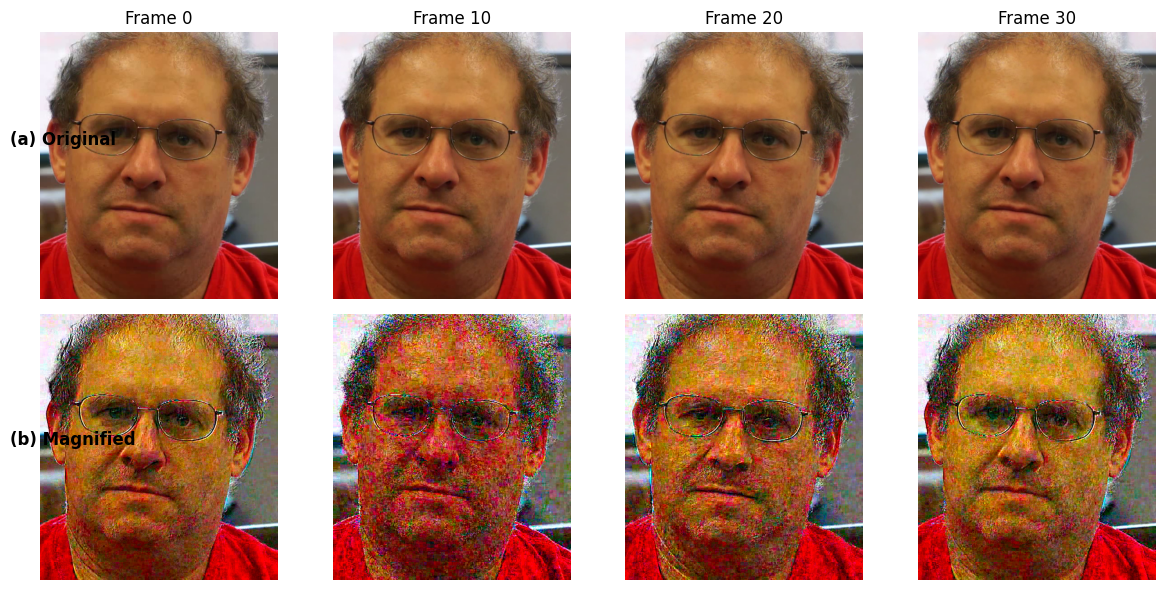

Saving video:   0%|          | 0/150 [00:00<?, ?it/s]

Video saved to magnified_face.mp4


True

In [10]:
# Create an instance of EulerianMagnification
evm = EulerianMagnification()

# Load face.mp4 from your Google Drive
video_path = 'face.mp4'
evm.load_video(video_path, max_frames=150, downsample_factor=1)

# Display original video
display(evm.play_video(evm.video, max_frames=60))

# Set parameters for magnification
evm.pyramid_levels = 5 #change value here to alter the pyramid levels
low_freq = 0.83  # Hz - for human heart rate ~50-100 BPM
high_freq = 1.0  # Hz
alpha = 30       # Amplification factor
lambda_c = 80    # Spatial cutoff wavelength
chromaticity_boost = 0.3  # Color enhancement

# Run magnification
evm.magnify(low_freq, high_freq, alpha, lambda_c, chromaticity_boost, color_space='lab')

# Display magnified video
display(evm.play_video(evm.processed_video, max_frames=60))

# Compare original vs magnified frames
evm.display_comparison(start_frame=0, end_frame=40, step=10)

# Save the processed video
evm.save_video("magnified_face.mp4")
